# Recurrent Neural Networks
This assignment aims to implement a simple LSTM from scratch using PyTorch.

Designed by Kien Nguyen Oct 2022.

This part will focus on RNN. In this part, you will learn how to prepare the data, define the model, train and test your model. In this part, you are asked to finish several tasks and report your results. Similar to CNN, you can also use Google Colab.

**Overview:**
- Implement a 1-layer LSTM from scratch using PyTorch
- Train and test the model on the provided dataset
- Implement the built-in 1-layer LSTM and conduct the training pipeline
- Implement the built-in 1-layer GRU and conduct the training pipeline
- Compare the three models implemented

## 1 - Import Python Packages

Run the following cell to import necessary packages for this part.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

import os


## 2 - Data Processing [5 points]

The following code will load the raw data stored in the specified ``csv`` file and inspect the overall data format. The machine learning task for this assignment is predicting stock's closing price of the next day given the prices from the previous. Therefore, our input should be a sequence of closing prices of the stock, and the output is the closing price of the next day.

In [44]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(os.path.join('data', filepath))
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


Plot the raw data.

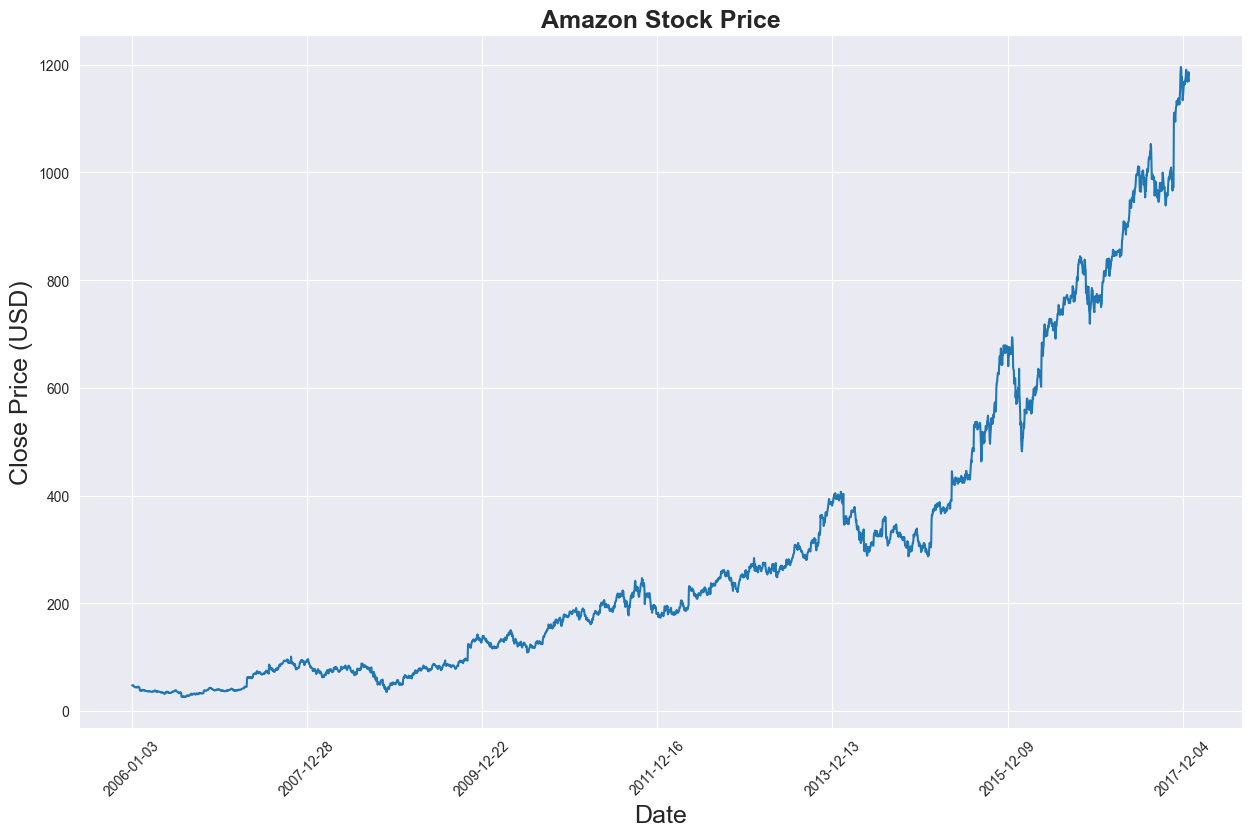

In [45]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


For this assignment, we focus on the closing price, so we extract the ``Close`` column in the data frame as our data.

In [46]:
price = data[['Close']]
price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


Then, we normalize the raw data into the range of ``[-1, 1]``.

In [47]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


/var/folders/7b/c30x0fmj4cqdhwpq4jls_68h0000gn/T/ipykernel_50853/3221609643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [48]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [49]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [50]:
# Convert to torch Tensor
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [51]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100
learning_rate = 0.01


cpu


## 3 - Define the Model [25 points]

Next, we will implement an LSTM cell using only PyTorch's ``torch.nn.Linear`` layer and some appropriate activation functions. Below is the formula of now to calculate different gates, the hidden state and the cell state for timestep ``t`` given the hidden state and the cell state from ``t-1`` and the input from ``t``. You can also refer to the official PyTorch's documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for more details.

Input gate: $i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

Forget gate: $f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

Cell gate: $g_t = \text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$

Output gate: $o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

Cell state: $c_t = f_t \odot c_{t-1} + i_t \odot g_t$

Hidden state: $h_t = o_t \odot \text{tanh}(c_t)$

where $\sigma$ denotes the sigmoid function and $\odot$ is the Hadamard product.

In [53]:
class LSTMCell(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, bias=True):
        super(LSTMCell, self).__init__()
        
        # Fill in the following lines
        self.Wii = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        self.Whi = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        
        self.Wif = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        self.Whf = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        
        self.Wig = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        self.Whg = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        
        self.Wio = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
        self.Who = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=bias, dtype=torch.float64)
    
    def forward(self, x, h, c):
        # Fill in the following lines
        it = self.Wii(x) + self.Whi(h)
        it = torch.sigmoid(it)
        
        ft = self.Wif(x) + self.Whf(h)
        ft = torch.sigmoid(ft)
        
        gt = self.Wig(x) + self.Whg(h)
        gt = torch.tanh(gt)
        
        ot = self.Wio(x) + self.Who(h)
        ot = torch.sigmoid(ot)
        
        ct = ft*c + it*gt
        ht = ot*torch.tanh(ct)
        
        return ht, ct
    

Now, use the above implemented LSTM cell to implement a 1-layer LSTM network. Note that we use the output embedding of the last timestep as the input to a linear layer that predicts the stock price. Here, we can see the LSTM cell as the feature extractor, with the linear layer being the regressor. 

**Note:** Don't forget to initialize the hidden and cell state at timestep 0. In standard practice, they are both zero vectors.

In [54]:
class LSTMNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(LSTMNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Fill in the following 2 lines
        self.lstm_cell = LSTMCell(input_dim, hidden_dim, bias)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, dtype=torch.float64)
        
    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros(self.hidden_dim, dtype=torch.float64).to(device)
        ct = torch.zeros(self.hidden_dim, dtype=torch.float64).to(device)
        
        # Use a for-loop to define the forward pass of the LSTM network
        for i in range(x.shape[1]):
            ht, ct = self.lstm_cell(x[:,i], ht, ct)
        
        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(ht)
        
        return output
    

## 4 -  Training and Testing

In this section, we conduct the training and testing of the LSTM network on the stock prediction task. First, define the model, loss function and optimizer. Note that it is a regression task, so the standard loss function is Mean Squared Error. For the optimizer, we can use the Adam optimizer.

In [55]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
model = LSTMNet(input_dim, hidden_dim, output_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


Run the code below to conduct the training of the model.

In [56]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.9388204063955388
Epoch  1 MSE:  0.8474251294345403
Epoch  2 MSE:  0.7621679691752434
Epoch  3 MSE:  0.6825668700063796
Epoch  4 MSE:  0.6080268632461333
Epoch  5 MSE:  0.5379875724797134
Epoch  6 MSE:  0.47203005744981924
Epoch  7 MSE:  0.40990734788434025
Epoch  8 MSE:  0.351518431923494
Epoch  9 MSE:  0.29687970758241605
Epoch  10 MSE:  0.24610896913360378
Epoch  11 MSE:  0.19941818804686118
Epoch  12 MSE:  0.15710908434472964
Epoch  13 MSE:  0.1195665779342356
Epoch  14 MSE:  0.08724568592825686
Epoch  15 MSE:  0.06064542574757498
Epoch  16 MSE:  0.04026018431929511
Epoch  17 MSE:  0.02649354167037347
Epoch  18 MSE:  0.019510754662390876
Epoch  19 MSE:  0.019002129160064517
Epoch  20 MSE:  0.02387438023017516
Epoch  21 MSE:  0.03206662236397093
Epoch  22 MSE:  0.04086752280151504
Epoch  23 MSE:  0.0477852490677545
Epoch  24 MSE:  0.05134325316822494
Epoch  25 MSE:  0.05125301555691256
Epoch  26 MSE:  0.04809417946870673
Epoch  27 MSE:  0.042871035104568286
Epoch  28

Plot the training predictions along with the losses through time (epochs).

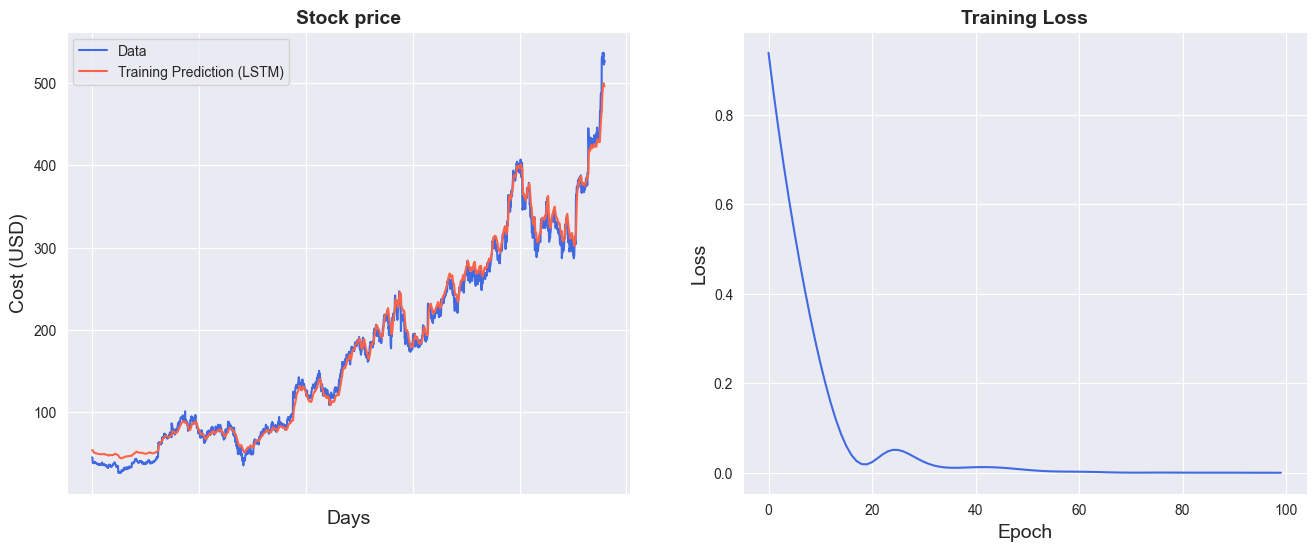

In [57]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


Make predictions on the testing set. Plot the training predictions through time (epochs).

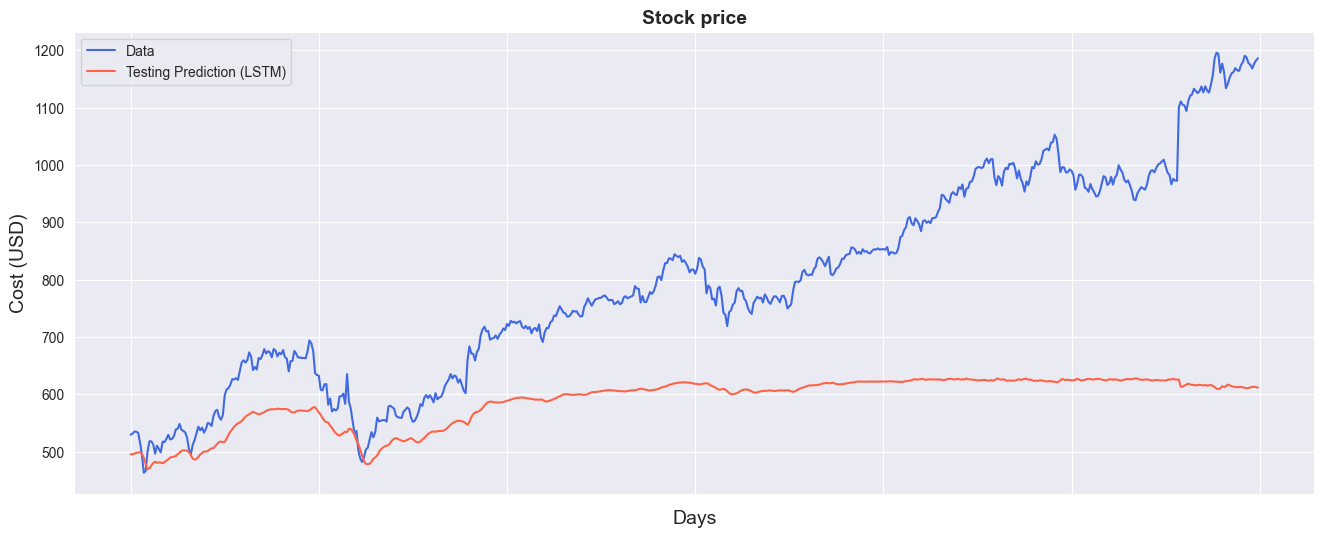

In [58]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


Calculate the MSE on both the training and testing data.

In [59]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
y_train_detach = y_train.detach().cpu().numpy()
y_train_pred_detach = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train_detach[:,0], y_train_pred_detach[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test_detach = y_test.detach().cpu().numpy()
y_test_pred_detach = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test_detach[:,0], y_test_pred_detach[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 0.02 RMSE
Test Score: 0.43 RMSE


## 5 - Built-in LSTM [10 points]

Use the provided code snippets and train a 1-layer LSTM network using the PyTorch built-in LSTM cell. Please show the prediction plots as well as the MSE on both training and testing data.

In [60]:
class LSTMNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(LSTMNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Fill in the following 2 lines
        self.lstm_cell = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, bias=bias, batch_first=True, dtype=torch.float64)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, dtype=torch.float64)
        
    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros((1,x.shape[0],self.hidden_dim), dtype=torch.float64).to(device)
        ct = torch.zeros((1,x.shape[0],self.hidden_dim), dtype=torch.float64).to(device)
        
        _, memory = self.lstm_cell(x, (ht, ct))
        ht, ct = memory
        
        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(ht)
        
        return output

In [61]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [62]:
# Convert to torch Tensor
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


In [63]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
model = LSTMNet(input_dim, hidden_dim, output_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [64]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))


/Users/gabrriel/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2399, 1])) that is different to the input size (torch.Size([1, 2399, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 MSE:  0.5031044115108061
Epoch  1 MSE:  0.4757606523989429
Epoch  2 MSE:  0.44886781336877957
Epoch  3 MSE:  0.4223147888597463
Epoch  4 MSE:  0.39598419289310116
Epoch  5 MSE:  0.369776262718293
Epoch  6 MSE:  0.34359621558324843
Epoch  7 MSE:  0.31733740357553675
Epoch  8 MSE:  0.2908834552565918
Epoch  9 MSE:  0.2641211763959353
Epoch  10 MSE:  0.23695731216203753
Epoch  11 MSE:  0.2093346567406406
Epoch  12 MSE:  0.18125063001096134
Epoch  13 MSE:  0.1527882672947334
Epoch  14 MSE:  0.12417502853690426
Epoch  15 MSE:  0.09589539477942177
Epoch  16 MSE:  0.06890250866495064
Epoch  17 MSE:  0.04499862376038403
Epoch  18 MSE:  0.027444260065782416
Epoch  19 MSE:  0.02152862214556761
Epoch  20 MSE:  0.03253818338137863
Epoch  21 MSE:  0.0530310858414639
Epoch  22 MSE:  0.06309788645728333
Epoch  23 MSE:  0.05862555051382796
Epoch  24 MSE:  0.04673274215783553
Epoch  25 MSE:  0.034714138735691756
Epoch  26 MSE:  0.02640549011372749
Epoch  27 MSE:  0.022474668490191422
Epoch  28

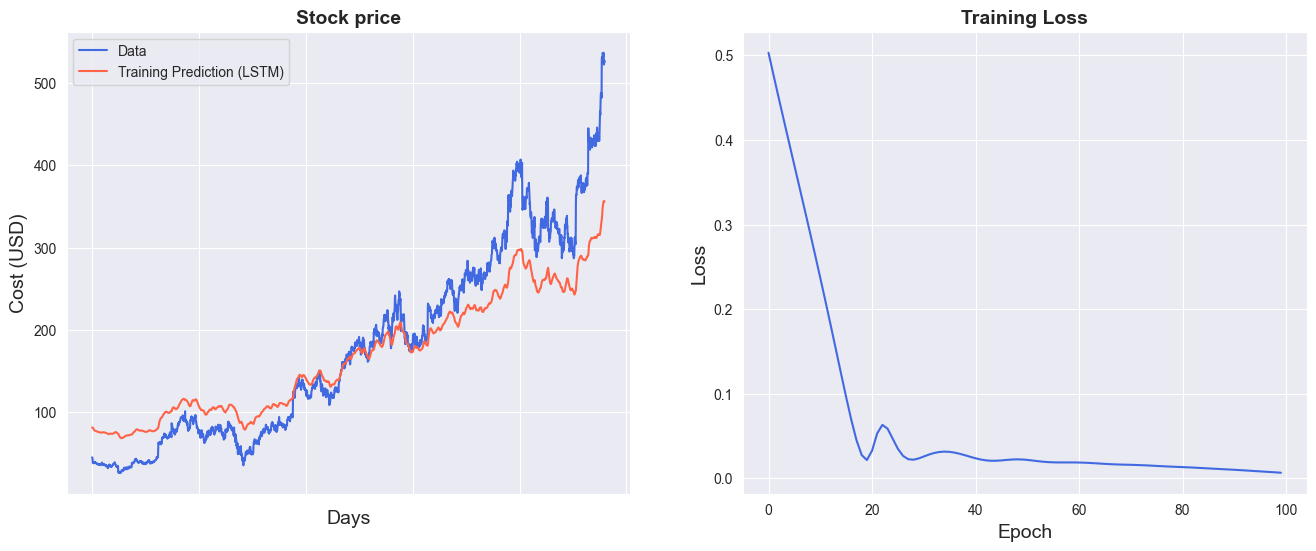

In [65]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy().squeeze(axis=0)))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


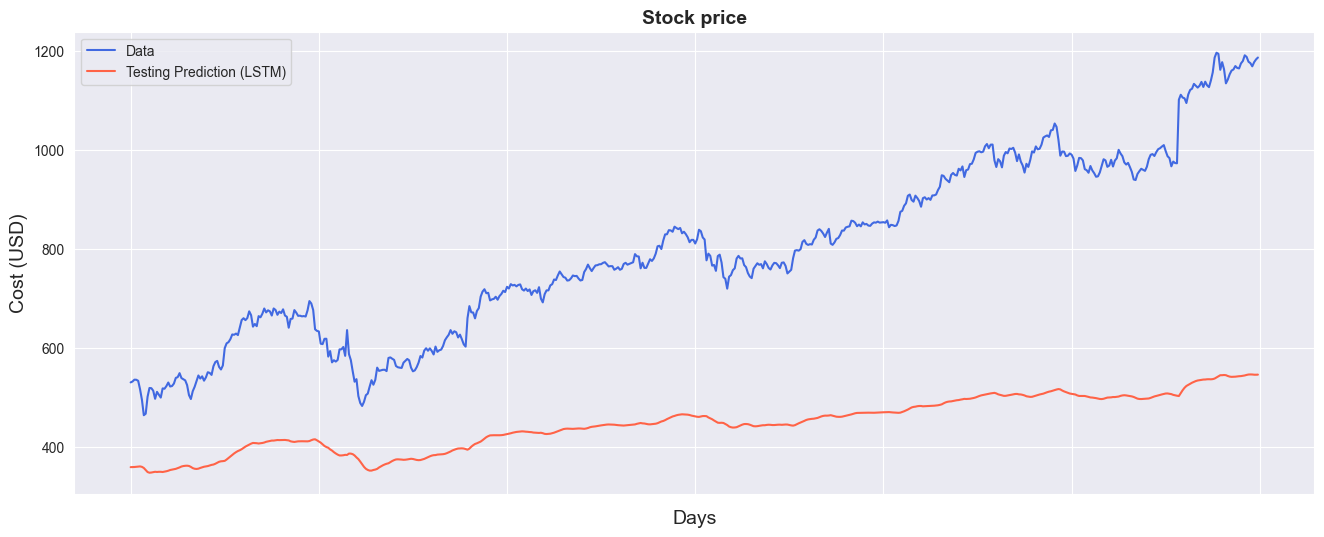

In [66]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy().squeeze(axis=0)))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


In [67]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
y_train_detach = y_train.detach().cpu().numpy()
y_train_pred_detach = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train_detach[:,0], y_train_pred_detach[0,:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test_detach = y_test.detach().cpu().numpy()
y_test_pred_detach = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test_detach[:,0], y_test_pred_detach[0,:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.08 RMSE
Test Score: 0.63 RMSE


## 6 - Built-in GRU [10 points]

Use the provided code snippets and train a 1-layer GRU network using the PyTorch built-in GRU cell. Please show the prediction plots as well as the MSE on both training and testing data.

In [69]:
class GRUNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(GRUNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Fill in the following 2 lines
        self.lstm_cell = torch.nn.GRU(input_size=input_dim, hidden_size=hidden_dim, bias=bias, batch_first=True, dtype=torch.float64)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, dtype=torch.float64)
        
    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros((1,x.shape[0], self.hidden_dim), dtype=torch.float64).to(device)
        
        _, ht = self.lstm_cell(x, ht)
        
        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(ht)
        
        return output

In [70]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [71]:
# Convert to torch Tensor
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


In [72]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
model = GRUNet(input_dim, hidden_dim, output_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [73]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))


/Users/gabrriel/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2399, 1])) that is different to the input size (torch.Size([1, 2399, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 MSE:  0.7225312866950233
Epoch  1 MSE:  0.6790931711267287
Epoch  2 MSE:  0.6363926698663626
Epoch  3 MSE:  0.5944222570858823
Epoch  4 MSE:  0.5531322070709406
Epoch  5 MSE:  0.5124352984006674
Epoch  6 MSE:  0.4722284308191551
Epoch  7 MSE:  0.43241245155716135
Epoch  8 MSE:  0.3929149317728749
Epoch  9 MSE:  0.3537058966878461
Epoch  10 MSE:  0.3148058177154404
Epoch  11 MSE:  0.27628996702751796
Epoch  12 MSE:  0.23829525877897473
Epoch  13 MSE:  0.20103652035973404
Epoch  14 MSE:  0.16483590894393874
Epoch  15 MSE:  0.13016696323942312
Epoch  16 MSE:  0.09771625536579706
Epoch  17 MSE:  0.06846483770266419
Epoch  18 MSE:  0.04378453968230187
Epoch  19 MSE:  0.025516768265203004
Epoch  20 MSE:  0.015906609908671595
Epoch  21 MSE:  0.016982555731799128
Epoch  22 MSE:  0.028428549941150637
Epoch  23 MSE:  0.04430426179383947
Epoch  24 MSE:  0.05557454653030702
Epoch  25 MSE:  0.057705913296420365
Epoch  26 MSE:  0.05197064728753427
Epoch  27 MSE:  0.04219048840116446
Epoch  

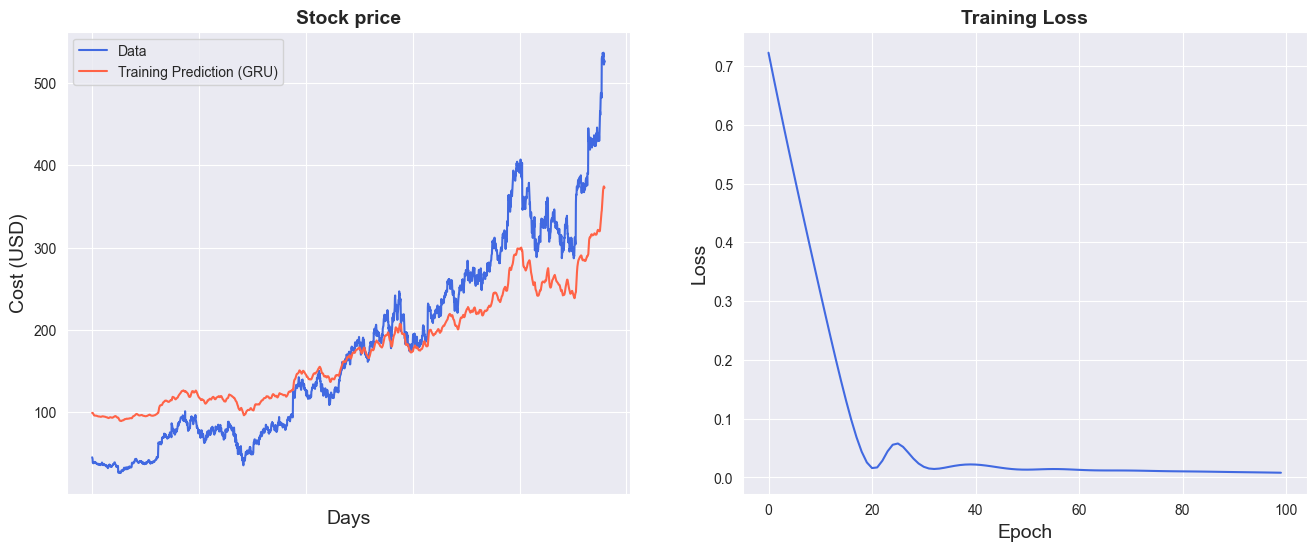

In [74]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy().squeeze(axis=0)))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


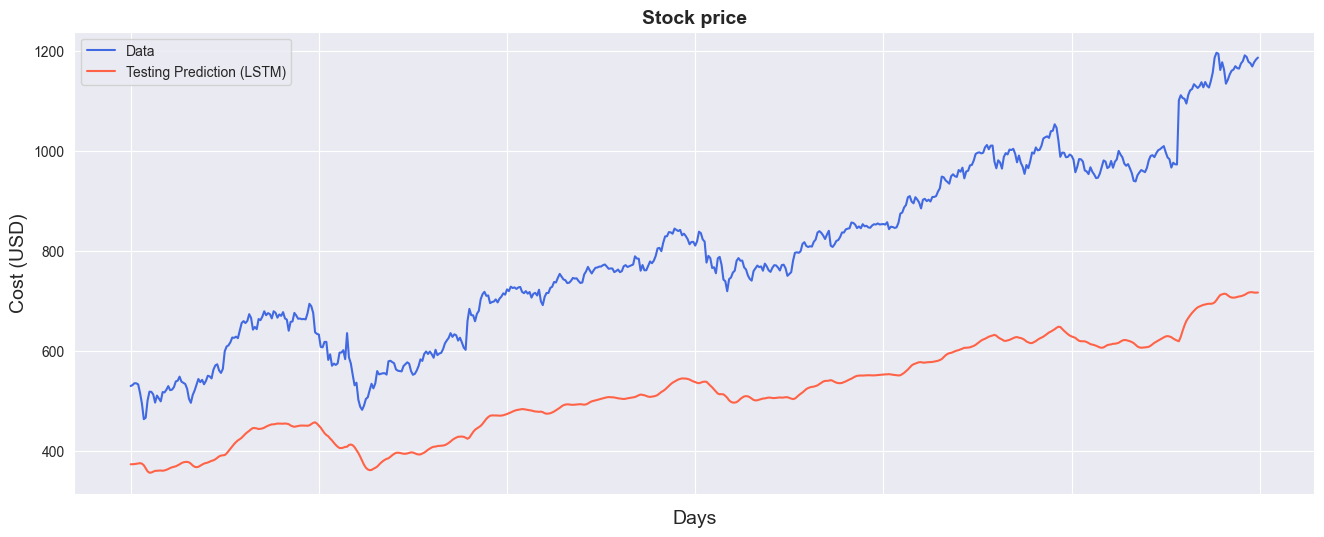

In [75]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy().squeeze(axis=0)))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


In [76]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
y_train_detach = y_train.detach().cpu().numpy()
y_train_pred_detach = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train_detach[:,0], y_train_pred_detach[0,:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test_detach = y_test.detach().cpu().numpy()
y_test_pred_detach = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test_detach[:,0], y_test_pred_detach[0,:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.09 RMSE
Test Score: 0.50 RMSE
